## Imports

In [2]:
import QuantumToolbox as qt
using Logging
import CairoMakie as cm
using MiniLoggers
using ProgressMeter
using LoggingExtras
using Revise
using Dates
using YAXArrays

import LsqFit as LF


In [3]:
import SuperconductingCavities as SC

## Logger Setups

In [4]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(InfoLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(22) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model

In [5]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

# Checking Collapse and Dephasing Ops

Image of the code used to construct the ops. Found in SuperconductingCavities/src/Circuits/Ciruit_Types/Transmon_Resonators/Constructor.jl

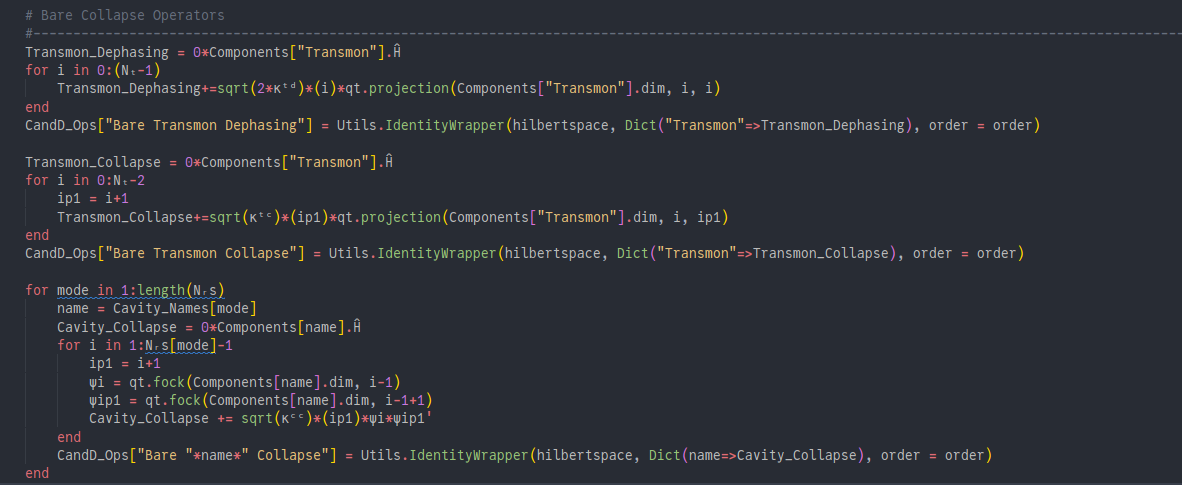

## ge dephasing

In [6]:
CandD_Check_ge = SC.Utils.LoadRunResults("Data/CheckingCollapseAndDephasing_with2.nc", cube_order = ["CheckingCollapseAndDephasing_with2"])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17K


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8  …  1998.2, …
  "states" => Any[Quantum Object:   type=Operator   dims=[10, 10]   size=(100, …

In [7]:
Proj_Ops_Temp_ge = SC.Utils.Get_Projection_Ops(Dict{Any, Any}((0,0) => Mode3.dressed_states[(0,0)], (1,0) => Mode3.dressed_states[(1,0)]))

EVs_ge = SC.Utils.Get_EVs(CandD_Check["states"], Proj_Ops_Temp_ge)

UndefVarError: UndefVarError: `CandD_Check` not defined

In [8]:
g0 = Mode3.dressed_states[(0,0)]
e0 = Mode3.dressed_states[(1,0)]

e_diag = []
ge_off_diag = []

for i in 1:length(CandD_Check_ge["states"])
    ρ = CandD_Check_ge["states"][i]
    push!(e_diag, e0'*ρ*e0)
    push!(ge_off_diag, g0'*ρ*e0)
end

In [9]:
to_fit(t, p) = 0.5*ℯ.^(-t.*p)

y = abs.(e_diag)
x = CandD_Check_ge["times"]

kappa1_ge_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1]


y = abs.(ge_off_diag)
x = CandD_Check_ge["times"]

kappa2_ge_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1];

In [27]:
println("ge kappa1_Fit: $kappa1_ge_Fit")
println("ge kappa2_Fit: $kappa2_ge_Fit")

kappaϕ_ge_Fit = (kappa2_ge_Fit-kappa1_ge_Fit/2)
println("ge kappaϕ_Fit: $kappaϕ_ge_Fit")



ge kappa1_Fit: 1.7867612935977286e-5
ge kappa2_Fit: 2.126525652146316e-5
ge kappaϕ_Fit: 1.2331450053474517e-5


In [29]:
println("Used ge kappa1: $(Mode3.params["kappa_tc"])")

kappa2 = Mode3.params["kappa_tc"]/2 + Mode3.params["kappa_td"]
println("Used ge kappa2: $(kappa2)")

println("Used ge kappaϕ: $(Mode3.params["kappa_td"])")

Used ge kappa1: 1.7857142857142855e-5
Used ge kappa2: 2.1276595744680852e-5
Used ge kappaϕ: 1.2348024316109425e-5


In [30]:
println("Experiment ge kappa1: $(1/56/1000)")
println("Experiment ge kappa2: $(1/47/1000)")

kappaϕ_ge_exp = 1/47/1000 - 1/56/1000/2
println("Experiment ge kappaϕ: $kappaϕ_ge_exp")

Experiment ge kappa1: 1.7857142857142855e-5
Experiment ge kappa2: 2.1276595744680852e-5
Experiment ge kappaϕ: 1.2348024316109425e-5


In [266]:
Mode3.params

Dict{Any, Any} with 15 entries:
  "Nrs"          => Any[10]
  "E_C"          => 0.102833
  "Cavity_Names" => Any["Mode 3"]
  "E_J"          => 26.9698
  "Nt_cut"       => 60
  "E_oscs"       => 6.22809
  "Nt"           => 10
  "ModelType"    => "TransmonResonators"
  "ng"           => 0
  "kappa_tc"     => 1.78571e-5
  "kappa_td"     => 1.2348e-5
  "kappa_cc"     => 1.0e-6
  "Model_Name"   => "Mode3"
  "gs"           => 0.0261844
  "Save_Path"    => "ModelSaves/Mode3/"

## gf dephasing

In [246]:
CandD_Check_gf = SC.Utils.LoadRunResults("Data/CheckingCollapseAndDephasing_with_2_gf_sqrt.nc", cube_order = ["CheckingCollapseAndDephasing_with_2_gf_sqrt"])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15K


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8  …  1998.2, …
  "states" => Any[Quantum Object:   type=Operator   dims=[10, 10]   size=(100, …

In [247]:
Proj_Ops_Temp_gf = SC.Utils.Get_Projection_Ops(Dict{Any, Any}((0,0) => Mode3.dressed_states[(0,0)], (1,0) => Mode3.dressed_states[(1,0)], (2,0) => Mode3.dressed_states[(2,0)]))

EVs_gf = SC.Utils.Get_EVs(CandD_Check_gf["states"], Proj_Ops_Temp_gf)

Dict{Any, Any} with 3 entries:
  (0, 0) => ComplexF64[0.5+0.0im, 0.5+7.89439e-20im, 0.5+3.76747e-20im, 0.5+9.2…
  (2, 0) => ComplexF64[0.5+0.0im, 0.499996-9.96392e-20im, 0.499993-8.67205e-20i…
  (1, 0) => ComplexF64[9.45429e-44+0.0im, 3.56941e-6-3.11061e-25im, 7.13886e-6-…

[2024-10-14 12:38:48] Info: Making Plot


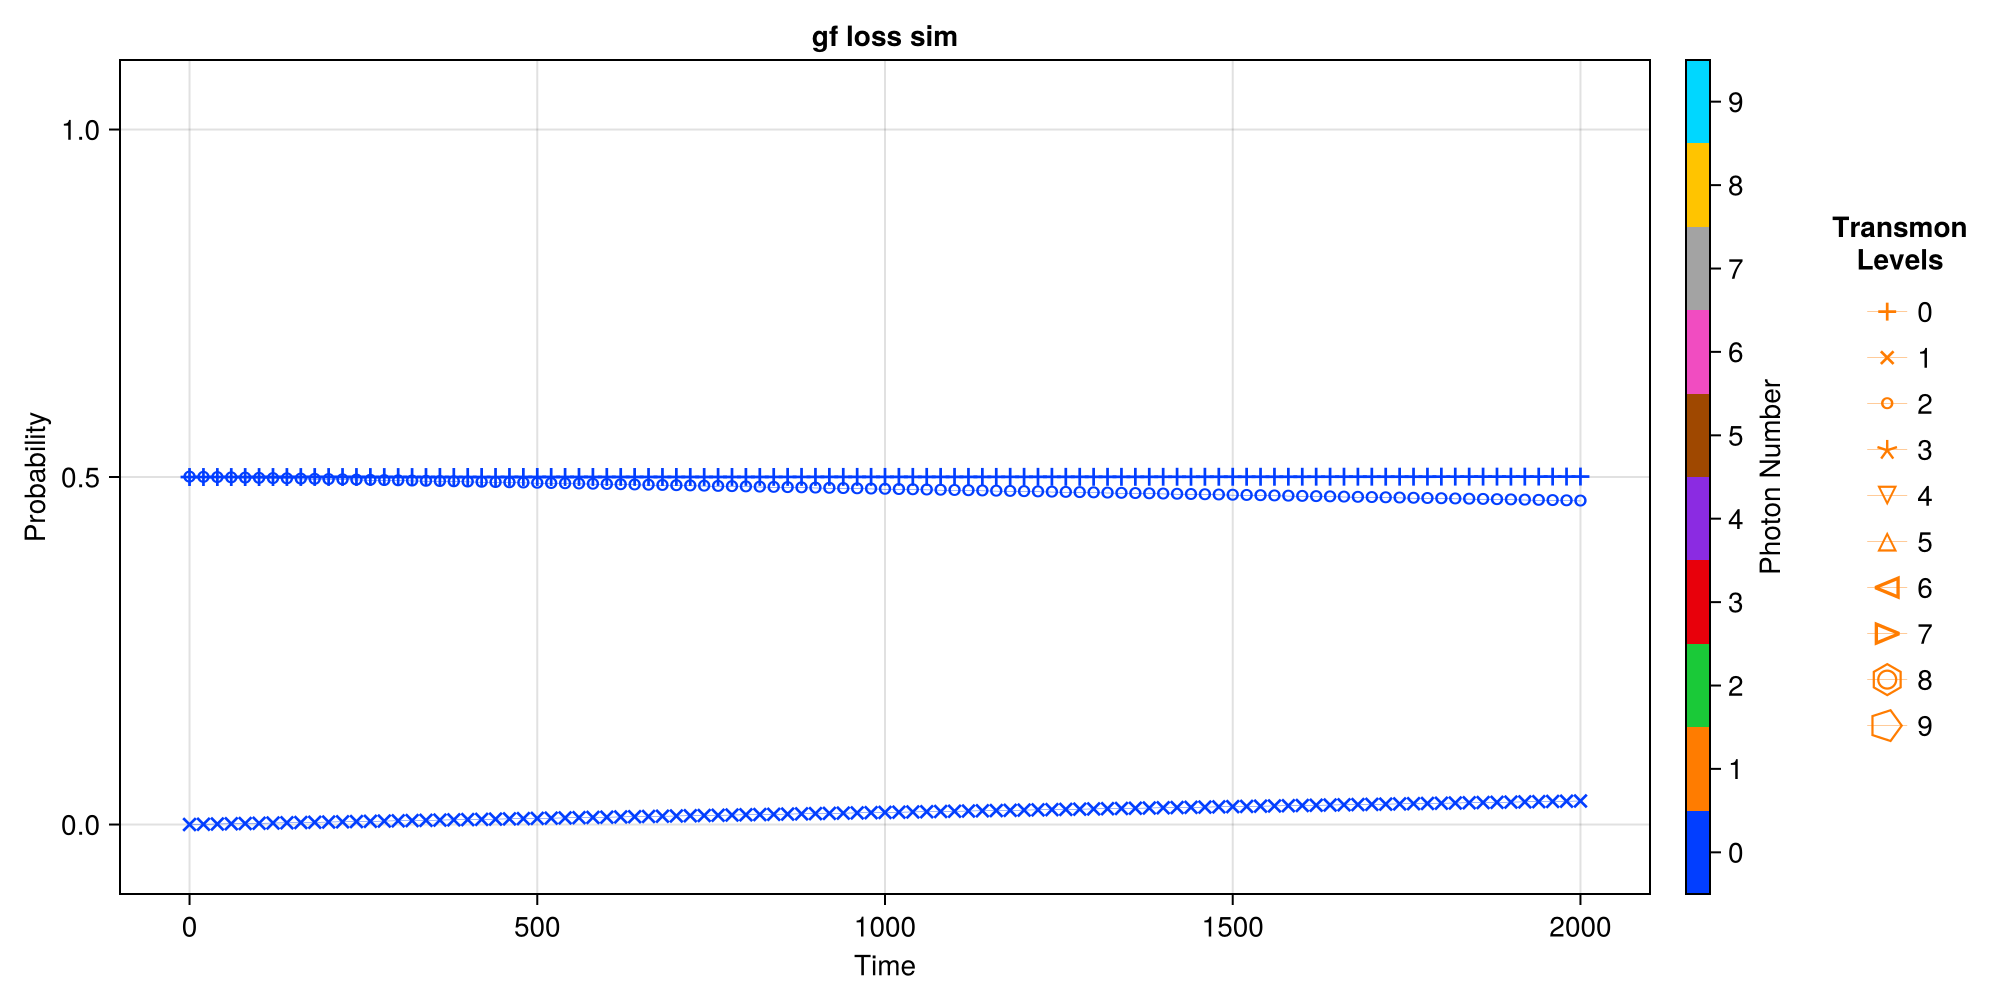

CairoMakie.Screen{IMAGE}


In [248]:
axis_kwargs = Dict{Any, Any}("title" => "gf loss sim")
SC.Dynamics.PlotSingleModeEvolution(Mode3, CandD_Check_gf["times"], EVs_gf, plot_every = 100, axis_kwargs = axis_kwargs)

In [249]:
g0 = Mode3.dressed_states[(0,0)]
f0 = Mode3.dressed_states[(2,0)]

f_diag = []
gf_off_diag = []

for i in 1:length(CandD_Check_gf["states"])
    ρ = CandD_Check_gf["states"][i]
    push!(f_diag, f0'*ρ*f0)
    push!(gf_off_diag, g0'*ρ*f0)
end

In [250]:
to_fit(t, p) = 0.5*ℯ.^(-t.*p)

y = abs.(f_diag)
x = CandD_Check_gf["times"]

kappa1_gf_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1]


y = abs.(gf_off_diag)
x = CandD_Check_gf["times"]

kappa2_gf_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1];

In [251]:
println("kappa1_Fit: $(kappa1_gf_Fit)")
println("kappa2_Fit: $kappa2_gf_Fit")

kappaϕ_gf_Fit = (kappa2_gf_Fit-kappa1_gf_Fit/2)
println("kappaϕ_Fit: $kappaϕ_gf_Fit")



kappa1_Fit: 3.5700880662120126e-5
kappa2_Fit: 4.2529341150739655e-5
kappaϕ_Fit: 2.4678900819679592e-5


In [252]:
kappa1_ef = Mode3.params["kappa_tc"]*(2)
println("Used kappa1: $(kappa1_ef)")

kappaϕ_gf = Mode3.params["kappa_td"]*2
kappa2_ef = (kappa1_ef)/2 + kappaϕ_gf
println("Used kappa2: $(kappa2_ef)")

println("Used kappaϕ: $(kappaϕ_gf)")

Used kappa1: 3.571428571428571e-5
Used kappa2: 4.2553191489361704e-5
Used kappaϕ: 2.469604863221885e-5


In [257]:
kappa1_ef_exp = 1/28/1000
kappa2_ef_exp = 1/36/1000
println("Experiment kappa1: $(kappa1_ef_exp)")
println("Experiment kappa2: $(kappa2_ef_exp)")

kappaϕ_exp = kappa2_ef_exp - kappa1_ef_exp/2
println("Experiment kappaϕ: $kappaϕ_exp")

Experiment kappa1: 3.571428571428571e-5
Experiment kappa2: 2.7777777777777776e-5
Experiment kappaϕ: 9.92063492063492e-6


In [265]:
println(1/kappa2_ef_exp/1000)
println(1/kappa2_ef/1000)

36.0
23.5


0.5773502691896258